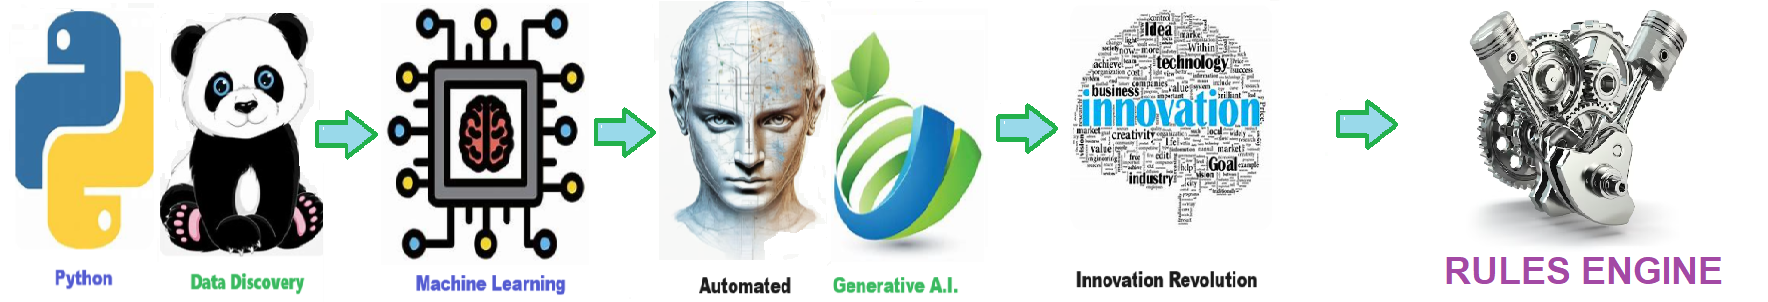

# Data Quality Rules Engine
1. Establish a Data Set repository
    - Meta data about each dat set worthy of quality check 
    - Include Data set type (Table, File, Schema, Directory) 
2. Define Rules
    - A simple set of rules that can be applied to all data sets
3. Assign Rules to data sets 
    - A simple set of rules that can be applied to all data sets    
4. Establish Data Set Quality Reference Measures
    - Permanently establish measures as a "benchmark" 
5. Execuate Data Set Quality Rules
    - Permanently establish measures as a "benchmark"     
6. Test rules individually
7. Test rules as a batch
8. Run dashboard / reporting / alert / escalation  

#### Required Setup Step 0 - Import all necessary Libraries

In [1]:
# Import Libraries for Spreadsheet Automation 
from datetime import date, datetime 
import os, glob, time
import file_manager as fm 
import pandas as pd 
import logging # built in python library that does not need to be installed 


import snowflake.connector
from platform import python_version

import sqlalchemy
from snowflake.connector.pandas_tools import write_pandas, pd_writer
from sqlalchemy import create_engine
from sqlalchemy.dialects import registry
registry.register('snowflake', 'snowflake.sqlalchemy', 'dialect')

print(f"Import Libraries Complete on Date:{datetime.now().strftime('%m-%d-%Y')} at Time:{datetime.now().strftime('%I:%M:%S %p') } ")

Import Libraries Complete on Date:04-25-2024 at Time:05:21:39 PM 


#### Required Setup Step 0 - Name the solution and initiate the logger 

In [2]:
# Configure the code and visual settings to have consistency 
import configparser
config = configparser.ConfigParser()
config.read('config.ini') 
solution_name = 'rules_engine'
current_working_directory = os.getcwd()

#### Required Setup Step 0 - - Create the local and remote directory structure if it does not exist.

- The Local repository houses a static version and archive of all reports and extracts. Untouched by others. 
- The remote repository houses a static version and archive of all reports and extracts. Can be modified. 

In [3]:
local_repository_path = r'Y:\rules'

local_directories = [
    os.path.join(local_repository_path ),
    os.path.join(local_repository_path,  'excel'),
]

for idx, directory in enumerate(local_directories):
    print(f"{idx+1} - {fm.create_non_existent_directory(directory)} ")

1 - Directory 'Y:\rules' already exists. 
2 - Directory 'Y:\rules\excel' already exists. 


#### Required Setup Step 0 - Get Snowflake Connection parameters and test connection

- The Local repository houses a static version and archive of all reports and extracts. Untouched by others. 
- The remote repository houses a static version and archive of all reports and extracts. Can be modified. 

In [5]:
snow_flake_user = config.get('Snowflake','user')
snow_flake_pwd = config.get('Snowflake','password')
snow_flake_account = config.get('Snowflake','account')

testing = False
if testing:
    print(f'The Snowflake connection paramters are: \n Snowflake User : {snow_flake_user} \n Snowflake pwd : {snow_flake_pwd} \n Snowflake Account: {snow_flake_account}')

In [6]:
def get_dataframe_from_SQL(SQL): 
    ctx = snowflake.connector.connect(user=snow_flake_user, password=snow_flake_pwd, account=snow_flake_account)
    cur = ctx.cursor()  # Create a cursor object.
    cur.execute(SQL) # Esecute the passed in SQL 
    df = cur.fetch_pandas_all()      # Fetch the result set from the cursor and deliver it as the Pandas DataFrame.
    cur.close()
    ctx.close()
    return df 

debugging_and_testing = True
if debugging_and_testing:
    sql = "select * from  DS_REFERENCE.REFERENCE_SCHEMA.dt_data_set_registry limit 20 "
    df_sample_to_test = get_dataframe_from_SQL(sql)
    if len(df_sample_to_test) > 1:
        print("SUCCESS - Snowflake connection successful")
    else: 
        print("ERROR - Snowflake connection NOT successful")

SUCCESS - Snowflake connection successful


In [7]:
def create_or_replace_data_set(df, table_name, db_name = 'DS_REFERENCE', schema_name = 'REFERENCE_SCHEMA', replace_or_append = 'replace'):
    user = snow_flake_user
    password = snow_flake_pwd
    constring = f'snowflake://{user}:{password}@{snow_flake_account}/{db_name}/{schema_name}'
    engine = create_engine(constring)

    con = engine.connect()
    if replace_or_append == 'replace':
        df.to_sql(table_name, engine, schema=schema_name, if_exists='replace', index=False, method=pd_writer)
        for role in ['WNY_ANALYST_READER', 'BUNDLED_ROLE_E47708B3_3F7C_46DD_9ED9_99DBF95E85A9']:
            con.execute(f'GRANT USAGE ON database "{db_name}" to {role}')
            con.execute(f'GRANT USAGE ON schema "{schema_name}" to {role}')
            con.execute(f'GRANT SELECT ON table {db_name}.{schema_name}.{table_name} to {role}')
        con.close()
    if replace_or_append == 'append':        
        df.to_sql(table_name, engine, schema=schema_name, if_exists='append', index=False, method=pd_writer)
    engine.dispose() 
    
    return(f"Table:{table_name} action:{replace_or_append} in db:{db_name} schema:{schema_name} data warehouse (snowflake) " )

In [8]:
local_repository_filename = r'c:\rules\excel\rules.xlsx'
df_rules =  pd.read_excel(local_repository_filename,index_col=False)
df_rules.head(5) 

,rule_id,rule,rule_description,returns
0,1,column count consistency,checks if a table or file contains a consisten...,"0 -Inconsistent, 1 - Inconsistent"


In [9]:
local_repository_filename = r'y:\rules\excel\data_set_registry.xlsx'
df_data_set_registry =  pd.read_excel(local_repository_filename,index_col=False)
df_data_set_registry.head(20) 

,DATA_SET_NAME,DATA_SET_TYPE,LOAD_TYPE,LOAD_RULES
0,Highmark Raw Membership,Directory,file,J:\IT GLIN Data Services Shared\CLAIMS_SOURCE\...
1,GLIN Network Patient Population,table,SQL,select * from WNY_DB.WNY_ANALYST.DS_NETWORK_P...
2,Krista File Raw,file,file,somewhere.csv
3,Krista File,table,file,select * from WNY_DB.WNY_ANALYST.DS_NETWORK_P...
4,Cancer Registry,table,SQL,SELECT * FROM WNY_DB.WNY_ANALYST.DS_ONCOLOGY_...
5,Medical Claims,teable,SQL,SELECT * FROM WNY_EDW_CUA.CUA_F_Medical_claim
6,wny_prod,schema,SQL,SELECT * FROM WNY_EDW_CUA.CUA_F_Medical_claim
7,BCBS,file,file,J://IT GLIN Data Services Shared//CLAIMS_SOURC...
8,Krista File,table,file,select * from WNY_DB.WNY_ANALYST.DS_NETWORK_P...
9,GLIN TABLE,table,SQL,select * from WNY_DB.WNY_ANALYST.DS_NETWORK_P...


In [10]:
peristing_to_snowflake = True 
if peristing_to_snowflake:
    print(create_or_replace_data_set(df_data_set_registry, 'dt_data_set_registry', 'DS_REFERENCE', 'REFERENCE_SCHEMA')) 
    
peristing_to_snowflake = True 
if peristing_to_snowflake:
    sql = "select * from  DS_REFERENCE.REFERENCE_SCHEMA.dt_data_set_registry limit 20 "
    df_data_set_registry = get_dataframe_from_SQL(sql)
    df_data_set_registry    

Table:dt_data_set_registry action:replace in db:DS_REFERENCE schema:REFERENCE_SCHEMA data warehouse (snowflake) 


In [11]:
peristing_to_snowflake = True 
if peristing_to_snowflake:
    sql = "select * from  DS_REFERENCE.REFERENCE_SCHEMA.dt_data_set_registry limit 20 "
    df_data_set_registry = get_dataframe_from_SQL(sql)
    df_data_set_registry

In [12]:
df_data_set_registry.head(20) 

,DATA_SET_NAME,DATA_SET_TYPE,LOAD_TYPE,LOAD_RULES
0,Highmark Raw Membership,Directory,file,J:\IT GLIN Data Services Shared\CLAIMS_SOURCE\...
1,GLIN Network Patient Population,table,SQL,select * from WNY_DB.WNY_ANALYST.DS_NETWORK_P...
2,Krista File Raw,file,file,somewhere.csv
3,Krista File,table,file,select * from WNY_DB.WNY_ANALYST.DS_NETWORK_P...
4,Cancer Registry,table,SQL,SELECT * FROM WNY_DB.WNY_ANALYST.DS_ONCOLOGY_...
5,Medical Claims,teable,SQL,SELECT * FROM WNY_EDW_CUA.CUA_F_Medical_claim
6,wny_prod,schema,SQL,SELECT * FROM WNY_EDW_CUA.CUA_F_Medical_claim
7,BCBS,file,file,J://IT GLIN Data Services Shared//CLAIMS_SOURC...
8,Krista File,table,file,select * from WNY_DB.WNY_ANALYST.DS_NETWORK_P...
9,GLIN TABLE,table,SQL,select * from WNY_DB.WNY_ANALYST.DS_NETWORK_P...


## STEP 2 - Establish the Rules Engine Basic Rule Set

In [13]:
def get_column_names(df):
    return( ','.join(df.columns))

def get_row_count(df):
    return(df.shape[0])

def get_column_count(df):
    return(df.shape[1])

def get_column_data_types(df):
    return( ','.join(df.dtypes.astype(str)))

def get_specific_column_count(df, column_name):
    return( len(df[column_name].unique()))

def get_filtered_column_count(df, filter_column, filter_value):
    filter = df[filter_column] == filter_value 
    df_filtered = df[filter]
    return(len(df_filtered)) 

def get_dynamic_filter_count(df, filter_column, filter_operation, filter_value):
    filter_expression = f"df['{filter_column}'] {filter_operation} '{filter_value}'"
    df_filtered = df[eval(filter_expression)]    
    return(len(df_filtered))

testing_df_functions = False 
if testing_df_functions:
    print(get_column_names(df_data_set_registry))
    print(get_row_count(df_data_set_registry)) 
    print(get_column_count(df_data_set_registry))
    print(get_column_data_types(df_data_set_registry))  
    print(get_column_count(df_data_set_registry))
    print(get_specific_column_count(df_data_set_registry,'DATA_SET_NAME'))       
    print(get_specific_column_count(df_data_set_registry,'DATA_SET_TYPE'))   
    print(get_filtered_column_count(df_data_set_registry,'DATA_SET_NAME','Krista File Raw'))   
    print(get_filtered_column_count(df_data_set_registry,'DATA_SET_TYPE','file'))   
    print(get_dynamic_filter_count(df_data_set_registry,'DATA_SET_NAME','==','Highmark Raw Membership'))    
    print(get_dynamic_filter_count(df_data_set_registry,'DATA_SET_TYPE','!=','file'))       
    print(get_dynamic_filter_count(df_data_set_registry,'DATA_SET_NAME','<=','Highmark Raw Membership'))          

In [15]:
df_highmark_test = pd.read_csv(r"J:\IT GLIN Data Services Shared\CLAIMS_SOURCE\BCBS\HN_OPA_44_MEMBERSHIP_NEW2_202312.txt", sep='|')
df_highmark_test.head()

C:\Users\JXE0313\AppData\Local\Temp\ipykernel_52516\4249491755.py:1: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  df_highmark_test = pd.read_csv(r"J:\IT GLIN Data Services Shared\CLAIMS_SOURCE\BCBS\HN_OPA_44_MEMBERSHIP_NEW2_202312.txt", sep='|')


,#GROUP_ID,GROUP_NAME,SUB_GROUP_ID,SUB_GROUP_NAME,CLIENT_ID,GRP_USER_DEF_1,GRP_USER_DEF_2,GRP_USER_DEF_3,GRP_USER_DEF_4,GRP_FILLER,...,PCP_COUNTY,PCP_PHONE_1,PCP_PHONE_1_EXT,PCP_FAX_1,PCP_FAX_1_EXT,MEMBER_STATUS,LINE_OF_BUSINESS_GROUP_TYPE,LINE_OF_BUSINESS_GROUP_PRODUCT_TYPE,ENR_PRIMARY,MEM_FILLER
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Y,NaN,COM,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Y,NaN,ASO,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Y,NaN,COM,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Y,NaN,COM,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Y,NaN,ASO,NaN,NaN


In [16]:
df = df_highmark_test
testing_df_functions = True 
if testing_df_functions:
    print(get_column_names(df))
    print(get_row_count(df)) 
    print(get_column_count(df))
    print(get_column_data_types(df))  
    print(get_column_count(df))
    print(get_specific_column_count(df,'LINE_OF_BUSINESS_GROUP_PRODUCT_TYPE'))       
    print(get_specific_column_count(df,'LINE_OF_BUSINESS_GROUP_PRODUCT_TYPE'))   
    print(get_filtered_column_count(df,'LINE_OF_BUSINESS_GROUP_PRODUCT_TYPE','COM'))   
    print(get_filtered_column_count(df,'LINE_OF_BUSINESS_GROUP_PRODUCT_TYPE','MC'))   
    print(get_filtered_column_count(df,'LINE_OF_BUSINESS_GROUP_PRODUCT_TYPE','MC'))       
    print(get_specific_column_count(df,'MEMBER_ID'))     
    print(get_specific_column_count(df,'PCP_ID'))       
    print(get_specific_column_count(df,'SBC_USER_DEF_1'))             
  
#     print(get_filtered_column_count(df,'LINE_OF_BUSINESS_GROUP_PRODUCT_TYPE','file'))   
#     print(get_dynamic_filter_count(df,'DATA_SET_NAME','==','Highmark Raw Membership'))  

#GROUP_ID,GROUP_NAME,SUB_GROUP_ID,SUB_GROUP_NAME,CLIENT_ID,GRP_USER_DEF_1,GRP_USER_DEF_2,GRP_USER_DEF_3,GRP_USER_DEF_4,GRP_FILLER,SUBSCRIBER_ID,COVERAGE_ID,COVERAGE_PLAN_ID,COVERAGE_TYPE,COVERAGE_DESC,SBC_USER_DEF_1,SBC_USER_DEF_2,SBC_USER_DEF_3,SBC_USER_DEF_4,SBC_FILLER,MEMBER_ID,FIRST_NAME,MIDDLE_INITIAL,LAST_NAME,SECONDARY_ID,DATE_OF_BIRTH,GENDER_CODE,RELATIONSHIP_CODE,MEDICARE_ID,MEDICAID_ID,MEMBER_EFFECTIVE_DATE,MEMBER_TERMINATION_DATE,MEMBER_ORIG_EFFECTIVE_DATE,ADDRESS_1,ADDRESS_2,ADDRESS_3,CITY,STATE,POSTAL_CODE,COUNTY,COUNTY_CODE,PHONE_1,PHONE_1_EXT,EMAIL,PCP_ID,PCP_NAME,PCP_SPECIALTY,PCP_STATUS,PCP_ADDRESS_1,PCP_ADDRESS_2,PCP_ADDRESS_3,PCP_CITY,PCP_STATE,PCP_POSTAL_CODE,PCP_COUNTY,PCP_PHONE_1,PCP_PHONE_1_EXT,PCP_FAX_1,PCP_FAX_1_EXT,MEMBER_STATUS,LINE_OF_BUSINESS_GROUP_TYPE,LINE_OF_BUSINESS_GROUP_PRODUCT_TYPE,ENR_PRIMARY,MEM_FILLER
44605
64
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,object,object,int64,float64,float64,f

In [17]:
df_data_set_registry.head()

,DATA_SET_NAME,DATA_SET_TYPE,LOAD_TYPE,LOAD_RULES
0,Highmark Raw Membership,Directory,file,J:\IT GLIN Data Services Shared\CLAIMS_SOURCE\...
1,GLIN Network Patient Population,table,SQL,select * from WNY_DB.WNY_ANALYST.DS_NETWORK_P...
2,Krista File Raw,file,file,somewhere.csv
3,Krista File,table,file,select * from WNY_DB.WNY_ANALYST.DS_NETWORK_P...
4,Cancer Registry,table,SQL,SELECT * FROM WNY_DB.WNY_ANALYST.DS_ONCOLOGY_...


### Fidelis Raw files - J:\IT GLIN Data Services Shared\CLAIMS_SOURCE\Fidelis Claims\Fidelis_Archive\Membership

## get a sample data set to profile and register attributes of. 

In [18]:
sample_filename = "J://IT GLIN Data Services Shared//CLAIMS_SOURCE//BCBS//BCBS_Archive//MEMBERSHIP\HN_OPA_44_MEMBERSHIP_GAP_202301.txt"        
df_membership = pd.read_csv(sample_filename, delimiter = "|", nrows = 10000)     
df_membership.head(2)    

,#GROUP_ID,GROUP_NAME,SUB_GROUP_ID,SUB_GROUP_NAME,CLIENT_ID,GRP_USER_DEF_1,GRP_USER_DEF_2,GRP_USER_DEF_3,GRP_USER_DEF_4,GRP_FILLER,...,PCP_COUNTY,PCP_PHONE_1,PCP_PHONE_1_EXT,PCP_FAX_1,PCP_FAX_1_EXT,MEMBER_STATUS,LINE_OF_BUSINESS_GROUP_TYPE,LINE_OF_BUSINESS_GROUP_PRODUCT_TYPE,ENR_PRIMARY,MEM_FILLER
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Y,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Y,NaN,NaN,NaN,NaN


In [19]:
df_data_set_registry.head()

,DATA_SET_NAME,DATA_SET_TYPE,LOAD_TYPE,LOAD_RULES
0,Highmark Raw Membership,Directory,file,J:\IT GLIN Data Services Shared\CLAIMS_SOURCE\...
1,GLIN Network Patient Population,table,SQL,select * from WNY_DB.WNY_ANALYST.DS_NETWORK_P...
2,Krista File Raw,file,file,somewhere.csv
3,Krista File,table,file,select * from WNY_DB.WNY_ANALYST.DS_NETWORK_P...
4,Cancer Registry,table,SQL,SELECT * FROM WNY_DB.WNY_ANALYST.DS_ONCOLOGY_...


In [20]:
local_repository_filename = r'c:\rules\excel\data_set_registry.xlsx'
df_data_set_registry =  pd.read_excel(local_repository_filename)
print(df_data_set_registry.columns)
df_data_set_registry.head(5) 

Index(['DATA_SET_NAME', 'DATA_SET_TYPE', 'LOAD_TYPE', 'LOAD_RULES'], dtype='object')


,DATA_SET_NAME,DATA_SET_TYPE,LOAD_TYPE,LOAD_RULES
0,Highmark Raw Membership,file,File,J://IT GLIN Data Services Shared//CLAIMS_SOURC...
1,GLIN Network Patient Population,table,SQL,select * from WNY_DB.WNY_ANALYST.DS_NETWORK_P...
2,Krista File Raw,file,file,somewhere.csv
3,Krista File,table,file,select * from WNY_DB.WNY_ANALYST.DS_NETWORK_P...
4,Cancer Registry,table,SQL,SELECT * FROM WNY_DB.WNY_ANALYST.DS_ONCOLOGY_...


In [21]:
def get_directory_files(target_directory, file_extension=None, file_name_contains=None):
    """ Get information about files in a directory matching the specified file extension. """
    # Initialize lists to store file information
    filenames = []
    file_sizes = []
    file_extensions  = []
    create_dates  = []

    # Traverse the directory and collect file information
    for root, _, files in os.walk(target_directory):
        for file in files:
            if file_extension is None or file.endswith(file_extension):
                if (file_name_contains is None) or (file_name_contains in file):
                    file_path = os.path.join(root, file)
                    filenames.append(file)
                    file_sizes.append(os.path.getsize(file_path))
                    file_extensions.append(os.path.splitext(file)[-1])
                    create_dates.append(pd.to_datetime(os.path.getctime(file_path), unit='s'))

    # Create a DataFrame from the collected information
    df_file_inventory = pd.DataFrame({
        'filename': filenames,
        'file_size': file_sizes,
        'extension': file_extensions,
        'create_date': create_dates
    })

    # Sort the DataFrame by filename
    df_file_inventory = df_file_inventory.sort_values(by='filename')

    return df_file_inventory

testing_get_directory_files = True
if testing_get_directory_files:
    target_directory = r"J://IT GLIN Data Services Shared//CLAIMS_SOURCE//BCBS//"
    file_extension = '.txt'  # Optional file extension filter
    file_contains = '44_MEMBERSHIP_NEW2_2023'  # Optional file extension filter    
    df_file_inventory = get_directory_files(target_directory, file_extension, file_contains)
    df = df_file_inventory
  
    
    print(df_file_inventory.shape)
 


(24, 4)


In [25]:
df = df_file_inventory
df_file_inventory.head(20) 

,filename,file_size,extension,create_date
0,HN_OPA_44_MEMBERSHIP_NEW2_202301.txt,11052105,.txt,2024-04-17 18:13:20.104169984
23,HN_OPA_44_MEMBERSHIP_NEW2_202301.txt,11052105,.txt,2024-04-17 20:02:30.281721088
12,HN_OPA_44_MEMBERSHIP_NEW2_202302.txt,11165972,.txt,2024-04-17 20:02:30.535203072
1,HN_OPA_44_MEMBERSHIP_NEW2_202302.txt,11165972,.txt,2024-04-17 18:13:20.995162880
13,HN_OPA_44_MEMBERSHIP_NEW2_202303.txt,11198987,.txt,2024-04-17 20:02:30.724212992
2,HN_OPA_44_MEMBERSHIP_NEW2_202303.txt,11198987,.txt,2024-04-17 18:13:21.151195136
14,HN_OPA_44_MEMBERSHIP_NEW2_202304.txt,11266821,.txt,2024-04-17 20:02:30.928209152
3,HN_OPA_44_MEMBERSHIP_NEW2_202304.txt,11266821,.txt,2024-04-17 18:13:21.543184128
15,HN_OPA_44_MEMBERSHIP_NEW2_202305.txt,11317539,.txt,2024-04-17 20:02:31.361222144
4,HN_OPA_44_MEMBERSHIP_NEW2_202305.txt,11317539,.txt,2024-04-17 18:13:21.920173056


In [26]:
for index, filename in enumerate(df.filename.unique()):
    print(f"file {filename} ")
    full_path = target_directory + filename
    df = pd.read_csv(full_path, sep='|')
    print(get_column_count(df))       
    print(get_specific_column_count(df,'LINE_OF_BUSINESS_GROUP_PRODUCT_TYPE'))   
    print(get_filtered_column_count(df,'LINE_OF_BUSINESS_GROUP_PRODUCT_TYPE','COM'))   
    print(get_filtered_column_count(df,'LINE_OF_BUSINESS_GROUP_PRODUCT_TYPE','MC'))   
    print(get_filtered_column_count(df,'LINE_OF_BUSINESS_GROUP_PRODUCT_TYPE','MC'))       
    print(get_specific_column_count(df,'MEMBER_ID'))     
    print(get_specific_column_count(df,'PCP_ID'))       
    print(get_specific_column_count(df,'SBC_USER_DEF_1'))    
    print("-------")        

file HN_OPA_44_MEMBERSHIP_NEW2_202301.txt 


C:\Users\JXE0313\AppData\Local\Temp\ipykernel_52516\2410878918.py:4: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(full_path, sep='|')


64
4
18914
12214
12214
41784
672
662
-------
file HN_OPA_44_MEMBERSHIP_NEW2_202302.txt 


C:\Users\JXE0313\AppData\Local\Temp\ipykernel_52516\2410878918.py:4: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(full_path, sep='|')


64
4
19192
12023
12023
42195
672
663
-------
file HN_OPA_44_MEMBERSHIP_NEW2_202303.txt 


C:\Users\JXE0313\AppData\Local\Temp\ipykernel_52516\2410878918.py:4: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(full_path, sep='|')


64
4
18806
12161
12161
42027
662
653
-------
file HN_OPA_44_MEMBERSHIP_NEW2_202304.txt 


C:\Users\JXE0313\AppData\Local\Temp\ipykernel_52516\2410878918.py:4: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(full_path, sep='|')


64
4
18700
12269
12269
42085
661
653
-------
file HN_OPA_44_MEMBERSHIP_NEW2_202305.txt 


C:\Users\JXE0313\AppData\Local\Temp\ipykernel_52516\2410878918.py:4: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(full_path, sep='|')


64
4
18601
12397
12397
42033
651
643
-------
file HN_OPA_44_MEMBERSHIP_NEW2_202306.txt 


C:\Users\JXE0313\AppData\Local\Temp\ipykernel_52516\2410878918.py:4: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(full_path, sep='|')


64
4
18325
12478
12478
41769
641
633
-------
file HN_OPA_44_MEMBERSHIP_NEW2_202307.txt 


C:\Users\JXE0313\AppData\Local\Temp\ipykernel_52516\2410878918.py:4: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(full_path, sep='|')


64
4
17877
12532
12532
40998
640
632
-------
file HN_OPA_44_MEMBERSHIP_NEW2_202308.txt 


C:\Users\JXE0313\AppData\Local\Temp\ipykernel_52516\2410878918.py:4: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(full_path, sep='|')


64
4
17819
12572
12572
41260
633
625
-------
file HN_OPA_44_MEMBERSHIP_NEW2_202309.txt 


C:\Users\JXE0313\AppData\Local\Temp\ipykernel_52516\2410878918.py:4: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(full_path, sep='|')


64
4
17593
12590
12590
41053
621
613
-------
file HN_OPA_44_MEMBERSHIP_NEW2_202310.txt 


C:\Users\JXE0313\AppData\Local\Temp\ipykernel_52516\2410878918.py:4: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(full_path, sep='|')


64
4
17489
12650
12650
40971
618
610
-------
file HN_OPA_44_MEMBERSHIP_NEW2_202311.txt 


C:\Users\JXE0313\AppData\Local\Temp\ipykernel_52516\2410878918.py:4: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(full_path, sep='|')


64
4
17403
12618
12618
40917
608
599
-------
file HN_OPA_44_MEMBERSHIP_NEW2_202312.txt 
64
4
17091
12610
12610
40513
586
577
-------


C:\Users\JXE0313\AppData\Local\Temp\ipykernel_52516\2410878918.py:4: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(full_path, sep='|')


In [27]:
data_set_name = 'test_data_set' 
attribute_name = 'column_count' 
attribute_value = 10 
df_data_set_registry.loc[len(df_data_set_registry)] = [data_set_name, attribute_name, attribute_value] 

ValueError: cannot set a row with mismatched columns

In [ ]:
df = df_membership

data_set_name = 'Highmark Membership' 
attribute_name = 'column_count' 
attribute_value = df.shape[1]
df_data_set_registry.loc[len(df_data_set_registry)] = [data_set_name, attribute_name, attribute_value] 

data_set_name = 'Highmark Membership' 
attribute_name = 'column_names' 
attribute_value = get_df_column_headers_string(df)
df_data_set_registry.loc[len(df_data_set_registry)] = [data_set_name, attribute_name, attribute_value] 

data_set_name = 'Highmark Membership' 
attribute_name = 'data_types' 
attribute_value = get_df_column_data_types_string(df) 
df_data_set_registry.loc[len(df_data_set_registry)] = [data_set_name, attribute_name, attribute_value] 

In [ ]:
df_data_set_registry.head()

In [ ]:
def get_data_set_value(df, dataset_name, attribute_name, output_type = None ):
    value = 'not_found'
    query_string = f"data_set_name == '{dataset_name}' and attribute_name == '{attribute_name}'"
    filtered_df = df.query(query_string)
    if not filtered_df.empty: 
        value = filtered_df['attribute_value'].iloc[0]
    if  output_type == 'print':       
        print(f"The {attribute_name} for {dataset_name} for is {value} " )        
    return value

attribut_value = get_data_set_value(df_data_set_registry, 'Highmark Membership', 'column_count', 'print')
attribut_value = get_data_set_value(df_data_set_registry, 'Highmark Membership', 'column_names', 'print')
attribut_value = get_data_set_value(df_data_set_registry, 'Highmark Membership', 'data_types', 'print')


In [ ]:
def test_structural_consistency(df, dataset_name , output_type = None):
    consistency_rules_passed = 0 
    if df.shape[1] == get_data_set_value(df_data_set_registry, 'Highmark Membership', 'column_count', output_type): 
        consistency_rules_passed += 1 
        if  output_type == 'print':   
            print(f"Column count {df.shape[1]} is consistent")
    if get_df_column_headers_string(df) == get_data_set_value(df_data_set_registry, 'Highmark Membership', 'column_names', output_type): 
        consistency_rules_passed += 1 
        if  output_type == 'print':           
            print(f"Column names are consistent")  
    if get_df_column_data_types_string(df) == get_data_set_value(df_data_set_registry, 'Highmark Membership', 'data_types', output_type): 
        consistency_rules_passed += 1 
        if  output_type == 'print':          
            print(f"Column data types are consistent") 
    return  consistency_rules_passed  

In [ ]:
def find_columns_not_in_other(string1, string2):
    """  Find columns present in one string of column names but not in the other. """ 
     # Split the strings into sets of column names
    columns_set1 = set(string1.split(','))
    columns_set2 = set(string2.split(','))
    columns_not_in_other = list(columns_set1 - columns_set2)     # Find columns present in set1 but not in set2
    return(' , '.join(columns_not_in_other))

testing_string_comparison = True
if testing_string_comparison: 
    string_1 = "test_ID,provider_id,test_name,i_need_a_lawyer,brownies_are_delicous"
    string_2 = "test_ID,test_name,brownies_suck"
    columns_not_in_other = find_columns_not_in_other(string_1, string_2)
    print(f"There are {len((columns_not_in_other))} columns present in string1 but not in string2:{columns_not_in_other} ")
    columns_not_in_other = find_columns_not_in_other(string_2, string_1)
    print(f"There are {len((columns_not_in_other))} columns present in string2 but not in string1:{columns_not_in_other} ")

In [ ]:
def get_structural_difference(df, dataset_name , output_type = None):
    difference = ""
    if df.shape[1] > get_data_set_value(df_data_set_registry, dataset_name, 'column_count', output_type): 
        difference += "The data has {df.shape[1] - get_data_set_value(df_data_set_registry, dataset_name)} more columns "
    if df.shape[1] < get_data_set_value(df_data_set_registry, dataset_name, 'column_count', output_type): 
        difference += "The data has {df.shape[1] - get_data_set_value(df_data_set_registry, dataset_name)} less columns "  
    if df.shape[1] == get_data_set_value(df_data_set_registry, dataset_name, 'column_count', output_type): 
        difference += "Column counts are equal  "          
        
    if get_df_column_headers_string(df) < get_data_set_value(df_data_set_registry, dataset_name, 'column_names', output_type): 
        difference +=  find_columns_not_in_other(df_column_headers_string(df),  get_data_set_value(df_data_set_registry, dataset_name, 'column_names', output_type))   
    if get_df_column_headers_string(df) > get_data_set_value(df_data_set_registry, dataset_name, 'column_names', output_type): 
        difference +=  find_columns_not_in_other(df_column_headers_string(df),  get_data_set_value(df_data_set_registry, dataset_name, 'column_names', output_type))   
    if get_df_column_headers_string(df) == get_data_set_value(df_data_set_registry, dataset_name, 'column_names', output_type): 
        difference +=  "Column Names are equal "   
       
    if get_df_column_data_types_string(df) < get_data_set_value(df_data_set_registry, dataset_name, 'data_types', output_type): 
        difference +=  "Sample Column Data Types are NOT equal to Model "  
        difference +=  f"\n\nMODEL >= {get_data_set_value(df_data_set_registry, dataset_name, 'data_types', output_type)} "  
        difference +=  f"\n\nSAMPLE = {get_df_column_data_types_string(df)} "  
    if get_df_column_data_types_string(df) > get_data_set_value(df_data_set_registry, dataset_name, 'data_types', output_type): 
        difference +=  "Sample Column Data Types are NOT equal to Model  "   
        difference +=  f"\n\nMODEL <= {get_data_set_value(df_data_set_registry, dataset_name, 'data_types', output_type)} "  
        difference +=  f"\n\nSAMPLE = {get_df_column_data_types_string(df)} "          
    if get_df_column_data_types_string(df) == get_data_set_value(df_data_set_registry, dataset_name, 'data_types', output_type): 
        difference +=  "Column Data Types are equal " 

        
    return  difference  

In [ ]:
test_structural_consistency(df_membership, 'Highmark Membership' , 'print' ) 

In [ ]:
test_structural_consistency(df_membership, 'Highmark Membership'  ) 

In [ ]:
df_file_inventory.filename.unique()

In [ ]:
def check_directory_consistency(target_dir, data_set_name):
    
    file_extension = '.txt'  # Optional file extension filter
    file_contains = '44_MEMBERSHIP_GAP_2023'  # Optional file extension filter    
    df_file_inventory = get_directory_files(target_directory, file_extension, file_contains)
    for idx, filename in enumerate(df_file_inventory.filename.unique()):
        filename = target_directory + filename
        if os.path.exists(filename):
            print(f"\nFile#{idx+1} \n {filename}\n")
            df_sample_file = pd.read_csv(filename, delimiter = "|", nrows = 10000) 
            unique_members = df_sample_file.MEMBER_ID.nunique()
            total_members = df_sample_file.shape[0]
            multi_plan_members = df_sample_file.shape[0] - df_sample_file.MEMBER_ID.nunique()        
            print(f"file rows:{df_sample_file.shape[0]} columns:{df_sample_file.shape[1]} unique:{unique_members} members and {multi_plan_members} multi plan members")
            data_consistency_score = test_structural_consistency(df_membership, data_set_name)
            if data_consistency_score == 3:
                print(f"The data is consistent with :{data_set_name} profile in registry  " ) 
            else:
                print(f"The data is NOT consistent with :{data_set_name} profile in registry  " )             
                print(f"{get_structural_difference(df_membership, data_set_name)} ")        
        else:
            print(f"The file does not exist ")


In [ ]:
target_directory = 'J://IT GLIN Data Services Shared//CLAIMS_SOURCE//BCBS//BCBS_Archive//MEMBERSHIP//'
data_set_name = 'Highmark Membership'
check_directory_consistency(target_directory, data_set_name)

In [ ]:
for  month  in range(1,13):
    if month < 10 :
        month_str = '0'+str(month)+".txt"
    else:
        month_str =  str(month)+".txt"
    year = '2023'
    filename= r'J://IT GLIN Data Services Shared//CLAIMS_SOURCE//BCBS//BCBS_Archive//MEMBERSHIP\HN_OPA_44_MEMBERSHIP_GAP_2023' + month_str
    if os.path.exists(filename):
        df_membership = pd.read_csv(filename, delimiter = "|", nrows = 10000) 
        unique_members = df_membership.MEMBER_ID.nunique()
        total_members = df_membership.shape[0]
        multi_plan_members = df_membership.shape[0] - df_membership.MEMBER_ID.nunique()        
        print(f"The year {year} month {month} total eligibility rows:{df_membership.shape[0]} unique:{unique_members} members and {multi_plan_members} multi plan members")
        data_set_name = 'Highmark Membership'
        data_consistency_score = test_structural_consistency(df_membership, 'Highmark Membership')
        if data_consistency_score == 3:
            print(f"The data is consistent with :{data_set_name} profile in registry  " ) 
        else:
            print(f"The data is NOT consistent with :{data_set_name} profile in registry  " )             
            print(f"{get_structural_difference(df_membership, 'Highmark Membership')} ")        
    else:
        print(f"The year {year} month {month} membership does not exist ")

In [ ]:
# Calculate and classify the process performance 
print("Current Date and Time:", datetime.now())
status = ql.calculate_process_performance(solution_name, start_time) 
print(ql.append_log_file(solution_name))  

## Background and alternative approaches below 

To identify the top free libraries in Python for building and managing a rules engine, we can consider factors such as popularity, flexibility, ease of use, and the level of support and documentation available. Here are some of the leading options:

1. **Drools**: While Drools is primarily a business rules management system (BRMS) written in Java, it can be integrated into Python applications using Jython, a Java implementation of Python. This allows Python applications to leverage Drools' powerful rules engine capabilities. Drools is known for its complex event processing, advanced decision tables, and a large community of users.

2. **PyKE (Python Knowledge Engine)**: PyKE is a highly flexible and dynamic Python library specifically designed for building knowledge-based and rule-based systems. It allows developers to separate the knowledge from the code and is excellent for scenarios where rules need to be updated frequently without changing the main application codebase.

3. **durable-rules**: This is a polyglot rules engine implemented in C and Python. It supports complex event processing and rulesets defined in a JSON-like language. `durable-rules` is designed for high performance and can handle a large number of events and rules, making it suitable for real-time applications.

4. **business-rules**: This Python library allows you to define business rules outside of your codebase in a readable, easily understandable format. It's particularly useful for applications where business logic changes often, and non-programmers need to update rules without delving into the code.

5. **ExpertSystem**: Although not a library, Python's `expertsystem` module can be used to build a rules engine. It requires a more manual setup compared to other libraries but offers flexibility in how rules and inference mechanisms are defined and executed.

Each of these libraries and systems has its strengths and is suited to different types of projects. The choice of which to use should be based on the specific requirements of your application, such as the complexity of the rules you need to manage, the performance characteristics of the engine, and how frequently your rules need to be updated.

If the criteria are to pick a library that is both professional, offering a flexible and extensible rules engine, and is relatively easy to learn and implement, **durable-rules** stands out as a strong candidate. Here's why:

### Why durable-rules?

- **Flexibility and Extensibility**: `durable-rules` is designed to be highly flexible, allowing for complex event processing, stateful rule evaluation, and support for both forward and reverse chaining of rules. It supports defining rules using a JSON-like syntax, making it adaptable to a wide range of applications and use cases. The library is also capable of handling a large volume of data efficiently, which is crucial for applications that require real-time processing.

- **Ease of Learning and Implementation**: One of the notable features of `durable-rules` is its straightforward and intuitive approach to defining rules. The syntax is clear and concise, making it easier for developers to learn compared to more complex rule engines that require understanding a specialized rules language or intricate API. Additionally, its integration with Python means that developers can leverage their existing Python knowledge and the extensive ecosystem of Python libraries to extend and customize their rules engine.

- **Performance**: Written in C and Python, `durable-rules` offers excellent performance, which is essential for applications that demand real-time decision making and high throughput.

- **Community and Documentation**: Although it may not have as large a community as some other technologies like Drools, `durable-rules` has adequate documentation to help new users get started and to support development efforts. The community around it, while smaller, is active and can provide assistance through various forums and platforms.

### Considerations:

While `durable-rules` is an excellent choice for many applications, it's always important to evaluate it against your specific project needs. If your application requires very complex rule logic or if you are working in an environment where Java integration is preferred (thus leaning towards Drools), it might be worth considering other options. However, for Python developers seeking a balance between professional capabilities and ease of use, `durable-rules` is a compelling choice.

Remember, the "best" choice depends on your project's unique requirements, including the complexity of the rules, the performance needs, and the team's familiarity with the underlying technology.

In [ ]:
first_install = False
if first_install: 
    !pip install durable-rules
    !pip install durable_rules --user

In [ ]:
# import durable-rules

# def run_rules():
#     # Clear any previous ruleset to avoid conflicts
#     clear_state('transactions')
    
#     # Define the ruleset
#     with ruleset('transactions'):
#         # Rule to identify large transactions
#         @when_all(m.amount > 100)
#         def large_transaction(c):
#             print(f"Large transaction detected: ${c.m.amount}")

#     # Post facts to the rules engine
#     post('transactions', {'amount': 150})
#     post('transactions', {'amount': 50})

# # Call the function to run the rules
# run_rules()
